**Анти-спам классификатор**

Для обучения моделей бинарной классификации сообщений (спам/не спам) на русском языке использовался датасет, собранный из нескольких других датасетов. Часть данных была на английском языке и, соответственно, переведена на русский язык с использованием библиотеки Deep-Translator.

Данные в датасете несбалансированы. Для оценки качества моделей будет применяться F1 мера. Также будут рассматриваться и другие метрики, такие как Precision, Recall, ROC-AUC.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import pickle
import re

seed = 56

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Датасет состоит из **66117** текстов разной длины.

In [ ]:
data = pd.read_csv('df.csv')
data = data[data['text'].notna() & (data['text'].str.strip() != '')]
data

,text,is_spam
0,Идите до Джуронг-Пойнт с ума сойти Доступно т...,0
1,Ладно лар Шучу с тобой чувак,0
2,Ты не можешь так рано говорить хо Ты можешь уж...,0
3,Нет я не думаю что он учится в USF он живет гд...,0
4,Привет дорогая прошло уже 3 недели а ответа н...,1
...,...,...
66114,Он хорош и пригоден для использования? [https:...,0
66115,"Я не уверен, что это лучший раздел для этого, ...",0
66116,"Было бы здорово, если бы кто-нибудь знал какие...",0
66117,"Поля = Хешрейт, VRAM, TDP, MSRP, Прибыль/день",0


Распределение классов неравномерное. Наблюдается дисбаланс классов, примерно 1 к 2.

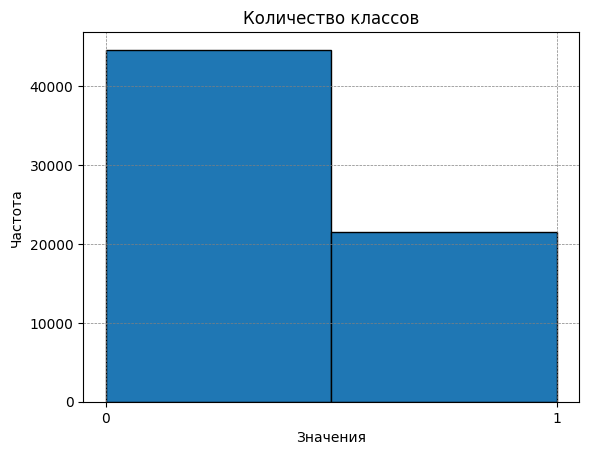

In [ ]:
plt.hist(data['is_spam'], bins=2, edgecolor='black')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.xticks([0,1])
plt.title('Количество классов')
plt.show()

Рассмотрим распределения длин текстов по количеству слов и символов.

In [ ]:
df_counts = pd.DataFrame()
df_counts['word_count'] = data['text'].apply(lambda x: len(x.split()))
df_counts['symbol_count'] = data['text'].apply(lambda x: len(x))

print('Максимальное кол-во слов в тексте:', df_counts['word_count'].max())
print('Максимальное кол-во символов в тексте:', df_counts['symbol_count'].max())

Максимальное кол-во слов в тексте: 1380
Максимальное кол-во символов в тексте: 5718


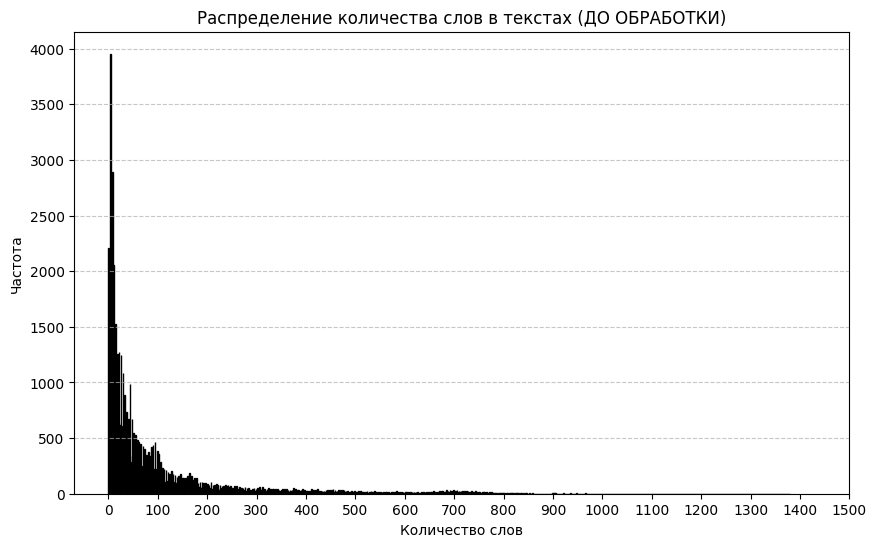

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_counts['word_count'], bins=1000, edgecolor='black', align='left')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.title('Распределение количества слов в текстах (ДО ОБРАБОТКИ)')
plt.xticks(range(0, 1600, 100))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

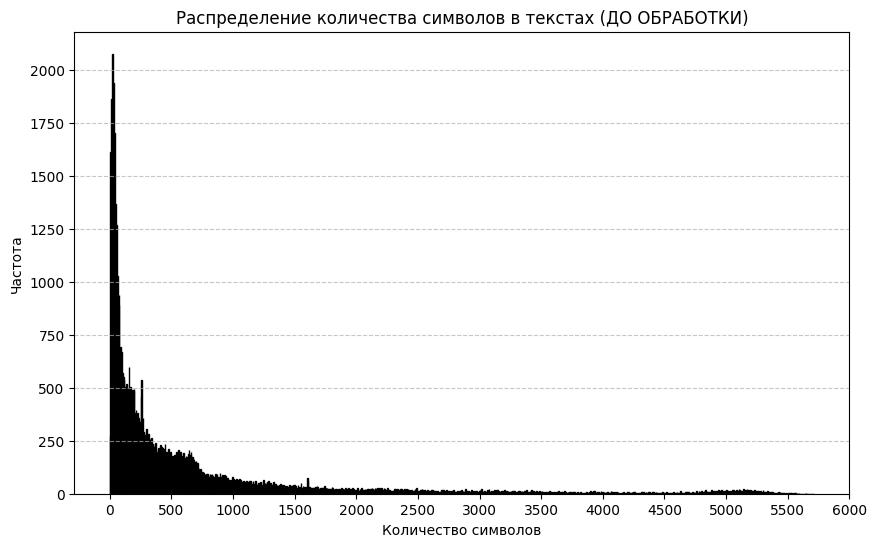

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_counts['symbol_count'], bins=1000, edgecolor='black', align='left')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.title('Распределение количества символов в текстах (ДО ОБРАБОТКИ)')
plt.xticks(range(0, 6100, 500))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Из приведенных выше графиков видно, объем текстов с небольшим количеством слов (меньше 50) и символов (меньше 100) превосходит над остальными.

**Обработаем датасет.** Отбросим лишние символы, стоп-слова, числа заменим на "num", тексты, начинающиеся на "https", "http", "www." на "link", произведем стемминг.

In [ ]:
stop_words = list(stopwords.words('russian'))
print(len(stop_words))
print(stop_words[:20])
# Сохранение списка для дальнейшего использования локально
with open('stop_words.txt', 'w', encoding='utf-8') as f:
    for word in stop_words:
        f.write(f"{word}\n")

151
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты']


In [ ]:
stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words("russian"))

# Функция для предобработки текста
def preprocess_text(text):
    if pd.isna(text):
        return ''
    # Приводим к нижнему регистру, удаляем спец. символы, заменяем ссылки на "link", числа на "num"
    text = re.sub(r'(https?://\S+|www\.\S+)', ' link ', text)
    text = re.sub(r'\d+', ' num ', text)
    text = re.sub(r'[\\=^#;|/,.!?:()+\-*<>\[\]{}\«»"\'`]', ' ', text)

    # Токенизация, стемминг, удаление стоп-слов
    words = text.lower().strip().split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    return ' '.join(words)

tqdm.pandas()
data['text'] = data['text'].progress_apply(lambda x: preprocess_text(x) if isinstance(x, str) else '')
data = data[data['text'].notna() & (data['text'].str.strip() != '')]
data

  0%|          | 0/66117 [00:00<?, ?it/s]

,text,is_spam
0,ид джуронг пойнт ум сойт доступн буфет bugis g...,0
1,ладн лар шуч тоб чувак,0
2,можеш ран говор хо можеш сказа,0
3,дума уч usf живет,0
4,привет дорог прошл num недел ответ хотел немн ...,1
...,...,...
66114,хорош пригод использован link,0
66115,увер эт лучш раздел поиск показа очевидн знает...,0
66116,здоров знал как действительн хорош набор дан м...,0
66117,пол хешрейт vram tdp msrp прибыл ден,0


In [ ]:
data.to_csv('df_stemmed_proccessed.csv', index=False)

Повторно рассмотрим распределения длин текстов по количеству слов и символов на обработанном датасете.

Максимальное количество слов и символов стало значительно больше. Распределения длин не изменились. Относительно короткие тексты по-прежнему в большинстве.

In [ ]:
df_counts = pd.DataFrame()
df_counts['word_count'] = data['text'].apply(lambda x: len(x.split()))
df_counts['symbol_count'] = data['text'].apply(lambda x: len(x))

print('Максимальное кол-во слов в тексте:', df_counts['word_count'].max())
print('Максимальное кол-во символов в тексте:', df_counts['symbol_count'].max())

Максимальное кол-во слов в тексте: 2525
Максимальное кол-во символов в тексте: 7674


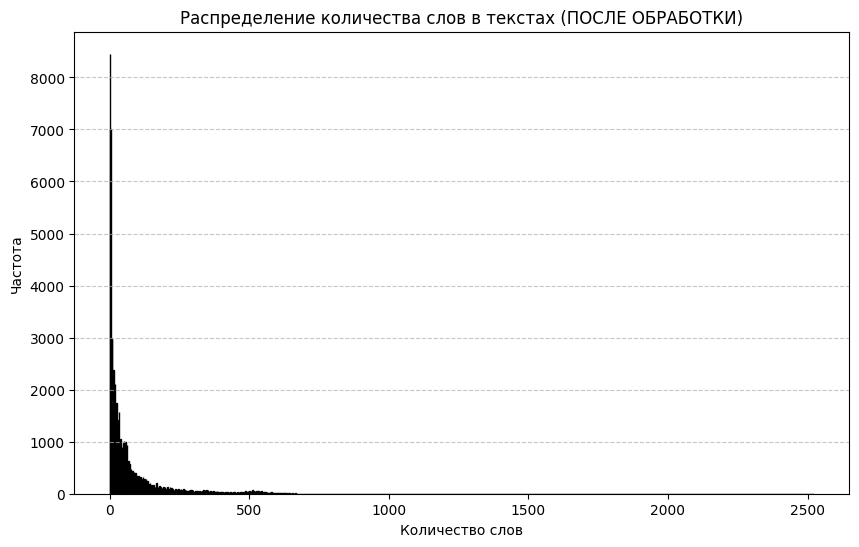

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_counts['word_count'], bins=1000, edgecolor='black', align='left')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.title('Распределение количества слов в текстах (ПОСЛЕ ОБРАБОТКИ)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

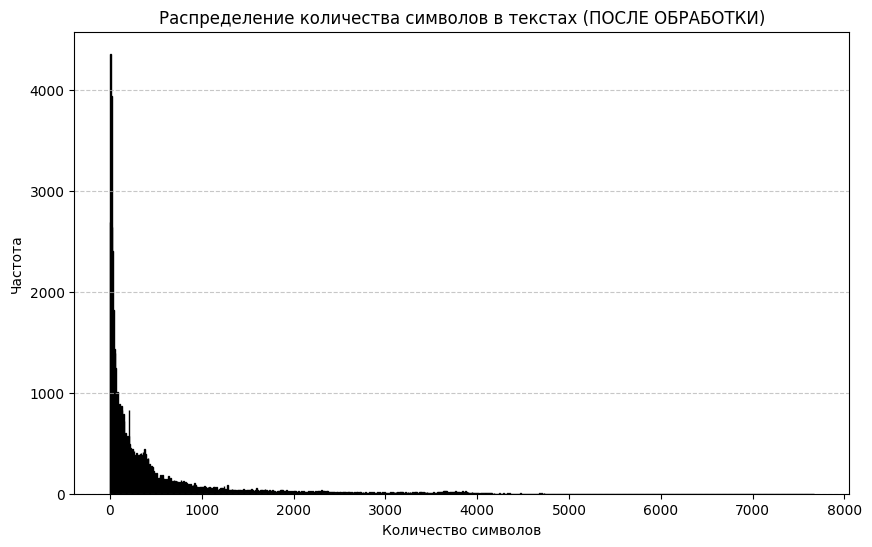

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_counts['symbol_count'], bins=1000, edgecolor='black', align='left')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.title('Распределение количества символов в текстах (ПОСЛЕ ОБРАБОТКИ)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Приступим к разделению данных на тренировочные и валидационные.

In [ ]:
data['is_spam'].value_counts()

,count
is_spam,
0,44405
1,21502


Соотношение первого класса (спам) к нулевому (не спам) равняется *2.07*

In [ ]:
data['is_spam'].value_counts()[0] / data['is_spam'].value_counts()[1]

2.065156729606548

Выделим 20% датасета на валидационную часть. Таким образом 52720 текстов пойдут в тренировочный набор, 13180 в валидационный.

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=seed)
X_train = train_data['text']
y_train = train_data['is_spam']
X_val = val_data['text']
y_val = val_data['is_spam']
print(f'Размер train: {len(train_data)}, размер val: {len(val_data)}')

Размер train: 52720, размер val: 13180


Соотношения классов в тренировочном и валидационном наборах примерно такое же, как в полном датасете.

In [ ]:
train_data['is_spam'].value_counts()

,count
is_spam,
0,35525
1,17195


In [ ]:
val_data['is_spam'].value_counts()

,count
is_spam,
0,8873
1,4307


# **TF-IDF**

Применим метод TF-IDF для обучения классификаторов.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Обучим TF-IDF Vectorizer для выделения 150 000 наиболее важных признаков.

In [ ]:
tfidf = TfidfVectorizer(max_features=150_000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [ ]:
# Функция для обучения и валидации дальнейших моделей
def train_and_evaluate_model(model, X_train_tfidf, X_val_tfidf, y_train, y_val):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)

    precision = precision_score(y_val, y_pred, average="binary")
    recall = recall_score(y_val, y_pred, average="binary")
    f1 = f1_score(y_val, y_pred, average="binary")
    rocauc = roc_auc_score(y_val, y_pred)
    return model, {"precision": precision, "recall": recall, "f1": f1, "roc-auc": rocauc}

results = {}

## SKLearn **Логистическая регрессия**

**Логистическая регрессия** показала результат **F1 = 0.9333, Precision = 0.9648, Recall = 0.9038, ROC-AUC = 0.9439.**

In [ ]:
log_reg = LogisticRegression(random_state=seed, n_jobs=-1)
log_reg, results["Logistic Regression"] = train_and_evaluate_model(log_reg, X_train_tfidf, X_val_tfidf, y_train, y_val)
print(results["Logistic Regression"])

{'precision': 0.9648079306071871, 'recall': 0.9038774088692826, 'f1': 0.9333493167106209, 'roc-auc': 0.9439369012113796}


## SKLearn **Случайный лес**

Для случайного леса рассмотрим несколько моделей с разным количеством деревьев.

In [ ]:
n_estimators_list = [10, 50, 100, 150, 200, 500]
best_f1 = 0
best_rf = None

for n_estimators in n_estimators_list:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=seed, n_jobs=-1)
    rf_clf, rf_results = train_and_evaluate_model(rf_clf, X_train_tfidf, X_val_tfidf, y_train, y_val)
    print(f"{n_estimators}: Precision: {rf_results['precision']:.4f}, Recall: {rf_results['recall']:.4f}, F1: {rf_results['f1']:.4f}, ROC-AUC: {rf_results['roc-auc']:.4f}")
    if rf_results['f1'] > best_f1:
        best_f1 = rf_results['f1']
        best_rf = rf_clf
        results["Random Forest"] = rf_results

10: Precision: 0.9685, Recall: 0.8732, F1: 0.9183, ROC-AUC: 0.9298
50: Precision: 0.9822, Recall: 0.9123, F1: 0.9460, ROC-AUC: 0.9522
100: Precision: 0.9842, Recall: 0.9170, F1: 0.9494, ROC-AUC: 0.9550
150: Precision: 0.9847, Recall: 0.9182, F1: 0.9503, ROC-AUC: 0.9557
200: Precision: 0.9855, Recall: 0.9184, F1: 0.9508, ROC-AUC: 0.9560
500: Precision: 0.9850, Recall: 0.9217, F1: 0.9523, ROC-AUC: 0.9575


Начиная от 150 деревьев сложность моделей сильно растет, однако рост метрик незначительный.

У ансамбля с 500 деревьями следующие метрики: **F1 = 0.9503, Precision = 0.9847, Recall = 0.9182, ROC-AUC = 0.9557.**

## CatBoost **Градиентный бустинг**

Рассмотрим градиентный бустинг над деревьями в библиотеке CatBoost.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
# CatBoost
model = CatBoostClassifier(random_seed=seed,
                    iterations=300,
                    eval_metric='F1',
                    custom_metric=['AUC', 'F1', 'Precision', 'Recall'],
                    use_best_model=True,
                    early_stopping_rounds=50,
                    verbose=50,
)

model.fit(X=X_train_tfidf, y=y_train, eval_set=(X_val_tfidf, y_val))

y_pred = model.predict(X_val_tfidf)

precision = precision_score(y_val, y_pred, average="binary")
recall = recall_score(y_val, y_pred, average="binary")
f1 = f1_score(y_val, y_pred, average="binary")
rocauc = roc_auc_score(y_val, y_pred)
results["CatBoost"] = {"precision": precision, "recall": recall, "f1": f1, "roc-auc": rocauc}
print(results["CatBoost"])

Learning rate set to 0.142459
0:	learn: 0.7481834	test: 0.7387644	best: 0.7387644 (0)	total: 4.46s	remaining: 22m 12s
50:	learn: 0.8877234	test: 0.8793832	best: 0.8793832 (50)	total: 1m 53s	remaining: 9m 16s
100:	learn: 0.9213915	test: 0.9079365	best: 0.9082031 (99)	total: 3m 43s	remaining: 7m 20s
150:	learn: 0.9371709	test: 0.9220701	best: 0.9222195 (146)	total: 5m 31s	remaining: 5m 26s
200:	learn: 0.9458914	test: 0.9299747	best: 0.9299747 (198)	total: 7m 16s	remaining: 3m 35s
250:	learn: 0.9505379	test: 0.9320809	best: 0.9320809 (250)	total: 9m 2s	remaining: 1m 45s
299:	learn: 0.9552659	test: 0.9345839	best: 0.9345839 (298)	total: 10m 54s	remaining: 0us

bestTest = 0.9345839346
bestIteration = 298

Shrink model to first 299 iterations.
{'precision': 0.9693190321776004, 'recall': 0.9022521476665892, 'f1': 0.9345839345839346, 'roc-auc': 0.9441949344215962}


Метрики градиентного бустинга оказались чуть хуже, чем у случайного леса.

**F1 = 0.9345, Precision = 0.9693, Recall = 0.9022, ROC-AUC = 0.9441.**

## Результаты

Сравним результаты всех обученных ранее моделей.

Наилучшие показатели по всем метрикам у случайного леса.

CatBoost и логистическая регрессия имеют очень похожие показатели метрик, однако CatBoost немного опережает логистическую регрессию.

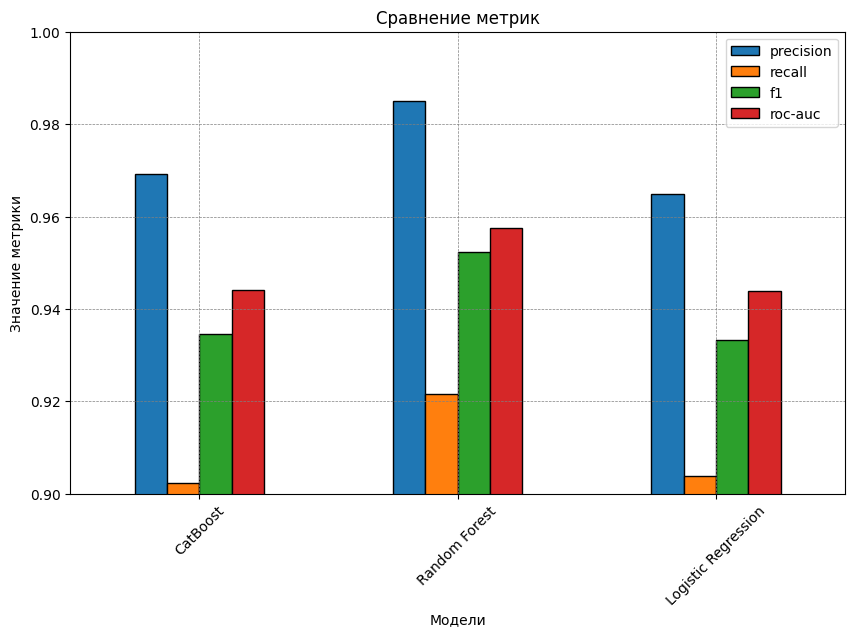

In [ ]:
def plot_metrics(results):
    metrics_df = pd.DataFrame(results).T
    metrics_df.plot(kind="bar", figsize=(10, 6), edgecolor='black')
    plt.title("Сравнение метрик")
    plt.xlabel("Модели")
    plt.ylabel("Значение метрики")
    plt.xticks(rotation=45)
    plt.ylim(0.9, 1)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.legend(loc="upper right")
    plt.show()

plot_metrics(results)

# **Рекуррентные сети**

Применим для решения задачи рекуррентную нейронную сеть.



In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from typing import List

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device

'cuda'

In [ ]:
data = pd.read_csv('df_stemmed_proccessed.csv')
data

,text,is_spam
0,ид джуронг пойнт ум сойт доступн буфет bugis g...,0
1,ладн лар шуч тоб чувак,0
2,можеш ран говор хо можеш сказа,0
3,дума уч usf живет,0
4,привет дорог прошл num недел ответ хотел немн ...,1
...,...,...
65896,хорош пригод использован link,0
65897,увер эт лучш раздел поиск показа очевидн знает...,0
65898,здоров знал как действительн хорош набор дан м...,0
65899,пол хешрейт vram tdp msrp прибыл ден,0


In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=seed)
X_train = train_data['text']
y_train = train_data['is_spam']
X_val = val_data['text']
y_val = val_data['is_spam']
print(f'Размер train: {len(train_data)}, размер val: {len(val_data)}')

Размер train: 52720, размер val: 13181


In [ ]:
MAX_TEXT_LEN = 100

Составим словарь для модели. Будем брать слова, которые встречаются более 25 раз.

Также добавим в словарь технические токены "unk" (неизвестный токен), "bos" (начало последовательности), "eos" (конец последовательности), "pad" (токен паддинга).

In [ ]:
words = Counter() # счетчик токенов
stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words("russian"))

for text in tqdm(train_data['text']):
    try:
        tokens = text.split()
    except AttributeError:
        print(text)

    for token in tokens:
        words[token] += 1

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25 ###

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

with open('vocab.pkl', 'wb') as file:
    pickle.dump(vocab, file)
with open('word2ind.pkl', 'wb') as file:
    pickle.dump(word2ind, file)
with open('ind2word.pkl', 'wb') as file:
    pickle.dump(ind2word, file)

  0%|          | 0/52720 [00:00<?, ?it/s]

Размер словаря: 11048


In [ ]:
assert 'num' in vocab

In [ ]:
assert 'link' in vocab

Определим класс WordDataset, который будет выполнять предобработку текста перед его подачей на вход модели.

Функция "collate_fn_with_padding" нужна для заполнения пустых мест токеном "pad" в матрице батча во время обучения и валидации.

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int):
        text = self.data.iloc[idx]['text']
        #text = re.sub(r'(https?://\S+|www\.\S+)', ' link ', text)
        #text = re.sub(r'\d+', ' num ', text)
        #text = re.sub(r'[\\=^#;|,!?:()+\-*<>\[\]{}\«»"\'`]', ' ', text)
        #text = text.lower().split()
        text = text.split()
        #text = [stemmer.stem(word) for word in text if word not in stop_words]

        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in text]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "is_spam": self.data.iloc[idx]['is_spam']
        }
        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=MAX_TEXT_LEN) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)
        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['is_spam'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'target_ids': labels
    }
    return new_batch

Создадим объекты датасетов и даталоадеров. Размер батча будет 2048.

In [ ]:
train_dataset = WordDataset(train_data)
eval_dataset = WordDataset(val_data)

g = torch.Generator()
g.manual_seed(seed)

batch_size = 2048
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size, generator=g)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size, generator=g)

Функция для валидации модели.

In [ ]:
def evaluate(model, eval_dataloader):
    predictions = []
    targets = []
    model.eval()
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).cpu()
            probabilities = torch.sigmoid(logits).flatten()
            predicted_labels = (probabilities > 0.5).float()

            predictions.append(predicted_labels)
            targets.append(batch['target_ids'].float())

    predictions = torch.cat(predictions).numpy()
    targets = torch.cat(targets).cpu().numpy()

    precision_ = precision_score(targets, predictions)
    recall_ = recall_score(targets, predictions)
    f1_ = f1_score(targets, predictions)
    rocauc_ = roc_auc_score(targets, predictions)

    return f1_, precision_, recall_, rocauc_

Функция для обучения модели.

In [ ]:
def train(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch=5,
          scheduler_step=2, scheduler_gamma=0.85):
    #torch.cuda.empty_cache()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    losses = []
    metrics = {
        'f1': [],
        'precision': [],
        'recall': [],
        'roc-auc': []
    }
    best_f1 = 0
    best_state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten().float())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)

        f1_, precision_, recall_, rocauc_  = evaluate(model, eval_dataloader)
        metrics['f1'].append(f1_)
        metrics['precision'].append(precision_)
        metrics['recall'].append(recall_)
        metrics['roc-auc'].append(rocauc_)

        print(f'  Loss: {avg_loss:.4f}, F1: {f1_:.4f}, Prec.: {precision_:.4f}, Recall: {recall_:.4f}, ROC-AUC: {rocauc_:.4f}')
        print(f"  Learning rate:  {optimizer.param_groups[0]['lr']:.7f}")

        if f1_ > best_f1:
            best_f1 = f1_
            best_state['model'] = model.state_dict()
            best_state['optimizer'] = optimizer.state_dict()

        scheduler.step()

    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(losses, marker='o', color='red')
    plt.xlabel('Эпохи')
    plt.ylabel('Лосс')
    plt.title('Лосс на обучении')

    # График метрик
    plt.subplot(1, 2, 2)
    plt.ylim(0.5, 1)
    plt.plot(metrics['f1'], marker='o', color='red', label='F1 Score')
    plt.plot(metrics['precision'], marker='o', color='orange', label='Precision')
    plt.plot(metrics['recall'], marker='o', color='green', label='Recall')
    plt.plot(metrics['roc-auc'], marker='o', color='blue', label='ROC-AUC')
    plt.xticks(np.arange(num_epoch)+1)
    plt.xlabel('Эпохи')
    plt.ylabel('Значение')
    plt.title('Показатели метрик')
    plt.legend(loc="lower right")
    plt.show()

    model.load_state_dict(best_state['model'])
    optimizer.load_state_dict(best_state['optimizer'])
    return best_state, metrics

**Архитектура рекуррентной модели.**

В качестве рекуррентного слоя будем использовать однослойную LSTM модификацию.

Выход LSTM слоя будет последовательно подаваться на вход трем линейным слоям, выполняющим роль классификатора. В качестве функции активации между линейными слоями будет использоваться гиперболический тангенс (Tanh). Для регуляризации модели будет применяться Dropout с вероятностью p=0.125.

На выходе рекуррентого слоя будет получаться трехмерный тензор размера (размер батча, длина последовательности, размер скрытого состояния). Для подачи его на вход линейным слоям необохдимо преобразовать его в двухмерный тензор размера (размер батча, размер скрытого состояния). Для такого преобразования будет использоваться аггрегация.

In [ ]:
# Архитектура рекуррентной модели
class LSTM_Classifier(nn.Module):
    def __init__(
        self, rnn_input_dim: int, hidden_dim: int, vocab_size: int,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, rnn_input_dim)
        self.rnn = nn.LSTM(rnn_input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, 1)
        self.act = nn.Tanh()
        self.dropout = nn.Dropout(p=0.125)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]  #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)    #[batch_size, hidden_dim]
        else: raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.fc1(self.act(output)))  # [batch_size, hidden_dim]
        outupt = self.dropout(self.fc2(self.act(output)))
        prediction = self.projection(self.act(output))  # [batch_size, 1]
        return prediction


Для подбора гиперпараметров, а именно размерность скрытого состояния линейных слоев (hidden_dim), размерность входов реккуретного слоя (rnn_input_dim) и тип аггрегации mean/max (aggregation_type), используем инструмент Optuna.



In [ ]:
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 128, 768)
    rnn_input_dim = trial.suggest_int('rnn_input_dim', 256, 1024)
    aggregation_type = trial.suggest_categorical('aggregation_t ype', ['mean', 'max'])

    model = LSTM_Classifier(rnn_input_dim=rnn_input_dim, hidden_dim=hidden_dim, \
                            vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())

    print(f'Обучение: hidden_dim: {hidden_dim}, rnn_input_dim: {rnn_input_dim}, agg_type: {aggregation_type}')
    rnn_stats, rnn_metrics = train(model, optimizer, criterion, \
                                    train_dataloader, eval_dataloader, num_epoch=5)

    return max(rnn_metrics['f1'])


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)


print("Наилучшие настройки:")
trial = study.best_trial
print("  F1: {}".format(trial.value))
print("  Параметры: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-03 14:28:29,586] A new study created in memory with name: no-name-0120280e-5e61-486a-949e-c889f69ea415


Обучение: hidden_dim: 128, rnn_input_dim: 559, agg_type: mean


Training epoch 1::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.5607, F1: 0.6405, Prec.: 0.7532, Recall: 0.5571, ROC-AUC: 0.7345
  Learning rate:  0.0010000


Training epoch 2::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.2591, F1: 0.9245, Prec.: 0.9435, Recall: 0.9063, ROC-AUC: 0.9400
  Learning rate:  0.0010000


Training epoch 3::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.1108, F1: 0.9467, Prec.: 0.9629, Recall: 0.9310, ROC-AUC: 0.9568
  Learning rate:  0.0008500


Training epoch 4::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0715, F1: 0.9554, Prec.: 0.9650, Recall: 0.9459, ROC-AUC: 0.9647
  Learning rate:  0.0008500


Training epoch 5::   0%|          | 0/26 [00:00<?, ?it/s]

[I 2025-01-03 14:29:40,843] Trial 0 finished with value: 0.9615067686874632 and parameters: {'hidden_dim': 128, 'rnn_input_dim': 559, 'aggregation_t ype': 'mean'}. Best is trial 0 with value: 0.9615067686874632.


  Loss: 0.0494, F1: 0.9615, Prec.: 0.9712, Recall: 0.9520, ROC-AUC: 0.9692
  Learning rate:  0.0007225
Обучение: hidden_dim: 478, rnn_input_dim: 368, agg_type: mean


Training epoch 1::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.5067, F1: 0.8120, Prec.: 0.8809, Recall: 0.7531, ROC-AUC: 0.8520
  Learning rate:  0.0010000


Training epoch 2::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.2084, F1: 0.9267, Prec.: 0.9354, Recall: 0.9182, ROC-AUC: 0.9438
  Learning rate:  0.0010000


Training epoch 3::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.1150, F1: 0.9440, Prec.: 0.9451, Recall: 0.9429, ROC-AUC: 0.9582
  Learning rate:  0.0008500


Training epoch 4::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0806, F1: 0.9536, Prec.: 0.9717, Recall: 0.9361, ROC-AUC: 0.9615
  Learning rate:  0.0008500


Training epoch 5::   0%|          | 0/26 [00:00<?, ?it/s]

[I 2025-01-03 14:31:59,534] Trial 1 finished with value: 0.9605946201038226 and parameters: {'hidden_dim': 478, 'rnn_input_dim': 368, 'aggregation_t ype': 'mean'}. Best is trial 0 with value: 0.9615067686874632.


  Loss: 0.0585, F1: 0.9606, Prec.: 0.9725, Recall: 0.9490, ROC-AUC: 0.9680
  Learning rate:  0.0007225
Обучение: hidden_dim: 699, rnn_input_dim: 826, agg_type: mean


Training epoch 1::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.4779, F1: 0.8953, Prec.: 0.8984, Recall: 0.8923, ROC-AUC: 0.9218
  Learning rate:  0.0010000


Training epoch 2::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.1574, F1: 0.9426, Prec.: 0.9550, Recall: 0.9305, ROC-AUC: 0.9547
  Learning rate:  0.0010000


Training epoch 3::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0857, F1: 0.9553, Prec.: 0.9637, Recall: 0.9471, ROC-AUC: 0.9649
  Learning rate:  0.0008500


Training epoch 4::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0538, F1: 0.9607, Prec.: 0.9610, Recall: 0.9604, ROC-AUC: 0.9708
  Learning rate:  0.0008500


Training epoch 5::   0%|          | 0/26 [00:00<?, ?it/s]

[I 2025-01-03 14:37:08,359] Trial 2 finished with value: 0.9611685073031706 and parameters: {'hidden_dim': 699, 'rnn_input_dim': 826, 'aggregation_t ype': 'mean'}. Best is trial 0 with value: 0.9615067686874632.


  Loss: 0.0346, F1: 0.9612, Prec.: 0.9797, Recall: 0.9434, ROC-AUC: 0.9670
  Learning rate:  0.0007225
Обучение: hidden_dim: 210, rnn_input_dim: 855, agg_type: mean


Training epoch 1::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.4865, F1: 0.8795, Prec.: 0.9134, Recall: 0.8480, ROC-AUC: 0.9046
  Learning rate:  0.0010000


Training epoch 2::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.1469, F1: 0.9461, Prec.: 0.9532, Recall: 0.9392, ROC-AUC: 0.9584
  Learning rate:  0.0010000


Training epoch 3::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0758, F1: 0.9566, Prec.: 0.9623, Recall: 0.9510, ROC-AUC: 0.9665
  Learning rate:  0.0008500


Training epoch 4::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0476, F1: 0.9631, Prec.: 0.9660, Recall: 0.9601, ROC-AUC: 0.9719
  Learning rate:  0.0008500


Training epoch 5::   0%|          | 0/26 [00:00<?, ?it/s]

[I 2025-01-03 14:38:44,172] Trial 3 finished with value: 0.9635325643714319 and parameters: {'hidden_dim': 210, 'rnn_input_dim': 855, 'aggregation_t ype': 'mean'}. Best is trial 3 with value: 0.9635325643714319.


  Loss: 0.0293, F1: 0.9635, Prec.: 0.9632, Recall: 0.9639, ROC-AUC: 0.9730
  Learning rate:  0.0007225
Обучение: hidden_dim: 276, rnn_input_dim: 605, agg_type: max


Training epoch 1::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.4440, F1: 0.8959, Prec.: 0.8985, Recall: 0.8932, ROC-AUC: 0.9223
  Learning rate:  0.0010000


Training epoch 2::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.1242, F1: 0.9461, Prec.: 0.9644, Recall: 0.9284, ROC-AUC: 0.9560
  Learning rate:  0.0010000


Training epoch 3::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0668, F1: 0.9564, Prec.: 0.9539, Recall: 0.9590, ROC-AUC: 0.9683
  Learning rate:  0.0008500


Training epoch 4::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0437, F1: 0.9605, Prec.: 0.9785, Recall: 0.9431, ROC-AUC: 0.9666
  Learning rate:  0.0008500


Training epoch 5::   0%|          | 0/26 [00:00<?, ?it/s]

[I 2025-01-03 14:40:28,876] Trial 4 finished with value: 0.9631615761249709 and parameters: {'hidden_dim': 276, 'rnn_input_dim': 605, 'aggregation_t ype': 'max'}. Best is trial 3 with value: 0.9635325643714319.


  Loss: 0.0277, F1: 0.9632, Prec.: 0.9634, Recall: 0.9629, ROC-AUC: 0.9726
  Learning rate:  0.0007225
Наилучшие настройки:
  F1: 0.9635325643714319
  Параметры: 
    hidden_dim: 210
    rnn_input_dim: 855
    aggregation_t ype: mean


Наилучшие гиперпараметры в Optuna оказались следующие:

    hidden_dim: 210
    rnn_input_dim: 855
    aggregation_t ype: mean

Инициализируем модель с гиперараметрами hidden_dim=256, rnn_input_dim=850. Рассмотрим данную модель с двумя типами аггрегации и выберем наилучший.

In [ ]:
# LSTM 1 LAYER | MEAN AGGREGATION
hidden_dim = 256
rnn_input_dim = 850
aggregation_type = 'mean'
model_mean_base = LSTM_Classifier(rnn_input_dim=rnn_input_dim, hidden_dim=hidden_dim, \
                        vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_mean_base = torch.optim.Adam(model_mean_base.parameters())

model_mean_base

LSTM_Classifier(
  (embedding): Embedding(11048, 850)
  (rnn): LSTM(850, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=1, bias=True)
  (act): Tanh()
  (dropout): Dropout(p=0.125, inplace=False)
)

Training epoch 1::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.4740, F1: 0.8521, Prec.: 0.9533, Recall: 0.7704, ROC-AUC: 0.8761
  Learning rate:  0.0010000


Training epoch 2::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.1490, F1: 0.9455, Prec.: 0.9601, Recall: 0.9312, ROC-AUC: 0.9563
  Learning rate:  0.0010000


Training epoch 3::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0783, F1: 0.9578, Prec.: 0.9626, Recall: 0.9531, ROC-AUC: 0.9676
  Learning rate:  0.0008500


Training epoch 4::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0489, F1: 0.9603, Prec.: 0.9748, Recall: 0.9462, ROC-AUC: 0.9672
  Learning rate:  0.0008500


Training epoch 5::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0308, F1: 0.9672, Prec.: 0.9753, Recall: 0.9592, ROC-AUC: 0.9738
  Learning rate:  0.0007225


Training epoch 6::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0207, F1: 0.9669, Prec.: 0.9731, Recall: 0.9608, ROC-AUC: 0.9740
  Learning rate:  0.0007225


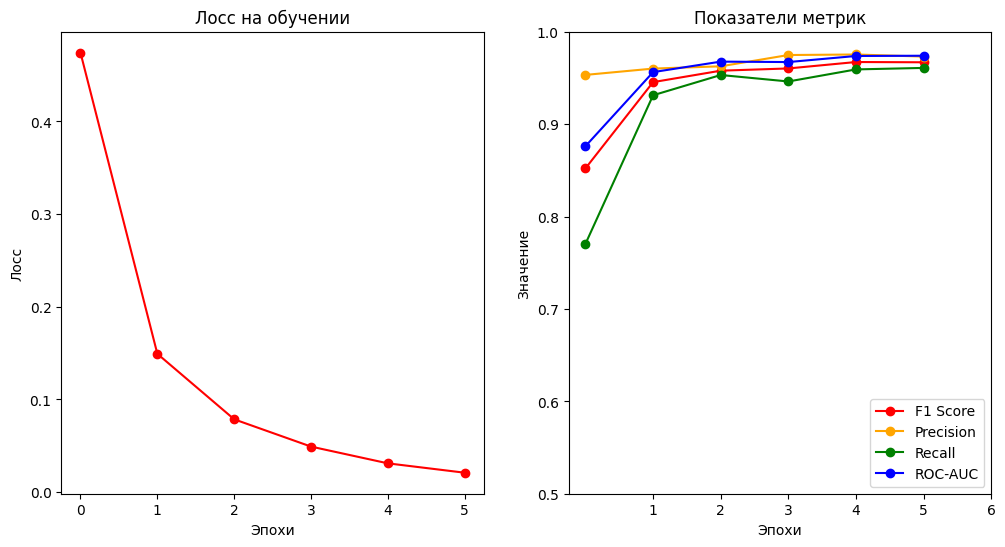

In [ ]:
num_epoch = 6
rnn_mean_base_stats, rnn_mean_base_metrics = train(model_mean_base, optimizer_mean_base, criterion, \
                                          train_dataloader, eval_dataloader, num_epoch=num_epoch)

Модель с mean-аггрегацией в результате обучения на 6 эпохах получила следующие параметры: **F1: 0.9669, Precision: 0.9731, Recall: 0.9608, ROC-AUC: 0.9740**

Training epoch 1::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.4144, F1: 0.9129, Prec.: 0.9328, Recall: 0.8937, ROC-AUC: 0.9313
  Learning rate:  0.0010000


Training epoch 2::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.1060, F1: 0.9565, Prec.: 0.9671, Recall: 0.9462, ROC-AUC: 0.9653
  Learning rate:  0.0010000


Training epoch 3::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0510, F1: 0.9670, Prec.: 0.9722, Recall: 0.9618, ROC-AUC: 0.9742
  Learning rate:  0.0008500


Training epoch 4::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0295, F1: 0.9605, Prec.: 0.9862, Recall: 0.9361, ROC-AUC: 0.9649
  Learning rate:  0.0008500


Training epoch 5::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0185, F1: 0.9666, Prec.: 0.9654, Recall: 0.9678, ROC-AUC: 0.9755
  Learning rate:  0.0007225


Training epoch 6::   0%|          | 0/26 [00:00<?, ?it/s]

  Loss: 0.0121, F1: 0.9687, Prec.: 0.9756, Recall: 0.9618, ROC-AUC: 0.9751
  Learning rate:  0.0007225


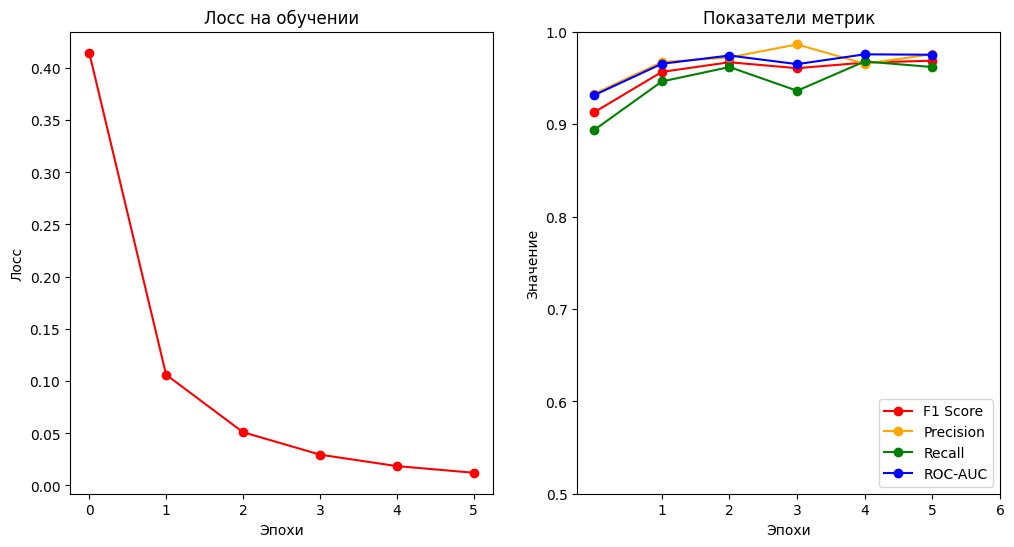

In [ ]:
# LSTM 1 LAYER | MAX AGGREGATION
hidden_dim = 256
rnn_input_dim = 850
model_max = LSTM_Classifier(rnn_input_dim=rnn_input_dim, hidden_dim=hidden_dim, \
                            vocab_size=len(vocab), aggregation_type='max').to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_max = torch.optim.Adam(model_max.parameters())

num_epoch = 6
rnn_max_stats, rnn_max_metrics = train(model_max, optimizer_max, criterion, \
                                          train_dataloader, eval_dataloader, num_epoch=num_epoch)

Модель с max-аггрегацией в результате обучения на 6 эпохах получила следующие параметры: **F1: 0.9687, Prec.: 0.9756, Recall: 0.9618, ROC-AUC: 0.9751**

Max-аггрегация справилась немного лучше, чем mean-аггрегация. Сохраним лучшую модель.

In [ ]:
torch.save(rnn_max_stats['model'], 'anti_spam_rnn_model.pth')
torch.save(rnn_max_stats['optimizer'], 'anti_spam_ rnn_optimizer.pth')

# **Модель на основе RuBert Tiny**


Рассмотрим файнтюнинг модели, использующей RuBert Tiny.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
import copy
seed = 56
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
MAX_TEXT_LEN = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Будем использовать необработанный датасет (без стемминга и удаления лишних символов).

In [ ]:
data = pd.read_csv('df.csv')
data = data[data['text'].notna() & (data['text'].str.strip() != '')]
data

,text,is_spam
0,Идите до Джуронг-Пойнт с ума сойти Доступно т...,0
1,Ладно лар Шучу с тобой чувак,0
2,Ты не можешь так рано говорить хо Ты можешь уж...,0
3,Нет я не думаю что он учится в USF он живет гд...,0
4,Привет дорогая прошло уже 3 недели а ответа н...,1
...,...,...
66114,Он хорош и пригоден для использования? [https:...,0
66115,"Я не уверен, что это лучший раздел для этого, ...",0
66116,"Было бы здорово, если бы кто-нибудь знал какие...",0
66117,"Поля = Хешрейт, VRAM, TDP, MSRP, Прибыль/день",0


In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=seed)
print(f'Размер train: {len(train_data)}, размер val: {len(val_data)}')

Размер train: 52893, размер val: 13224


Создадим класс RuBertDataset, который будет использваоть RuBert Tiny токенизатор.

In [ ]:
class RuBertDataset(Dataset):
      def __init__(self, sentences, tokenizer, max_length=MAX_TEXT_LEN):
          self.tokenizer = tokenizer
          self.data = sentences
          self.max_length = max_length

      def __len__(self):
          return len(self.data)

      def __getitem__(self, idx):
          text = self.data.iloc[idx]['text']
          label = self.data.iloc[idx]['is_spam']
          encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
          return {'input_ids': encoding['input_ids'].squeeze(), 'attention_mask': encoding['attention_mask'].squeeze(), 'labels': torch.tensor(label)}


tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
train_dataset = RuBertDataset(train_data, tokenizer, max_length=MAX_TEXT_LEN)
val_dataset = RuBertDataset(val_data, tokenizer, max_length=MAX_TEXT_LEN)

g = torch.Generator()
g.manual_seed(seed)

batch_size = 2048

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=g)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Будем использовать RuBert Tiny для обработки входной последовательности. Выходы трансформера будут подаваться на вход классификатора, состоящего из трех линейных слоев с активацией ELU и регуляризацией Dropout (p=0.1).

In [ ]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: nn.Module, hidden_size=256):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = base_transformer_model

        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, hidden_size),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ELU(),
            nn.Dropout(p=0.1),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        output = self.backbone(input_ids=input_ids, attention_mask=attention_mask)

        output = output.last_hidden_state[:, 0]
        #print(output.shape)
        output = self.classifier(output)
        return output

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

def train_transformer(model: TransformerClassificationModel, train_loader: DataLoader, val_loader: DataLoader,
                      freeze_backbone: bool = True, num_epochs: int = 3, learning_rate: float = 5e-4,
                      scheduler_step: int = 1, scheduler_gamma : float = 0.9):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    train_losses = []
    val_losses = []
    metrics = {'f1': [], 'precision': [], 'recall': [], 'roc-auc': []}

    if freeze_backbone:
        model = freeze_backbone_function(model)

    print('Total params:', sum(p.numel() for p in model.parameters()))
    print('Trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
   # scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=len(train_loader) * num_epochs)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
   # scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=9)
    criterion = nn.BCEWithLogitsLoss()

    best_state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    best_f1 = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f'Training epoch {epoch+1}:'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).reshape(-1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].float().to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask).reshape(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

              #  preds = outputs.cpu().numpy()
                preds = (outputs > 0.5).float().cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_precision = precision_score(all_labels, all_preds, average="binary")
        val_f1 = f1_score(all_labels, all_preds, average="binary")
        val_recall = recall_score(all_labels, all_preds, average="binary")
        val_auc = roc_auc_score(all_labels, all_preds)

        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state['model'] = model.state_dict()
            best_state['optimizer'] = optimizer.state_dict()

        val_losses.append(avg_val_loss)
        metrics['recall'].append(val_recall)
        metrics['f1'].append(val_f1)
        metrics['precision'].append(val_precision)
        metrics['roc-auc'].append(val_auc)

        print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} | F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, ROC-AUC: {val_auc:.4f}")
        print(f"  Learning rate:  {optimizer.param_groups[0]['lr']:.7f}")
        scheduler.step()

    print(f'\nBest F1: {best_f1:.5f}')
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(val_losses, label='Val Loss', marker='o', color='red')
    plt.plot(train_losses, label='Train Loss', marker='o', color='blue')
    plt.xlabel('Эпохи')
    plt.ylabel('Лосс')
    plt.legend()
    plt.title('Лосс на тренировке')

    plt.subplot(1, 2, 2)
    plt.ylim(0.5, 1)
    plt.plot(metrics['f1'], marker='o', color='red', label='F1 Score')
    plt.plot(metrics['precision'], marker='o', color='orange', label='Precision')
    plt.plot(metrics['recall'], marker='o', color='green', label='Recall')
    plt.plot(metrics['roc-auc'], marker='o', color='blue', label='ROC-AUC')

    plt.xticks(np.arange(num_epochs)+1)
    plt.xlabel('Эпохи')
    plt.ylabel('Значение')
    plt.title('Показатели метрик')
    plt.legend()
    plt.show()

    model.load_state_dict(best_state['model'])
    return best_state, metrics


Создадим объект модели с размерностью скрытого состояния линейных слоев классификатора равной 256.

In [ ]:
hidden_size = 256
rubert_tiny_freezed_model = TransformerClassificationModel(AutoModel.from_pretrained("cointegrated/rubert-tiny2"), hidden_size)
rubert_tiny_freezed_model

TransformerClassificationModel(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), ep

Произведем файнтюнинг модели, обучая только слои классификатора, на 6 эпохах.

Total params: 29339945
Trainable params: 146177


Training epoch 1::   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.7010, Val Loss: 0.6655 | F1: 0.2909, Precision: 0.9932, Recall: 0.1704, ROC-AUC: 0.5849
  Learning rate:  0.0010000


Training epoch 2::   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.6236, Val Loss: 0.6053 | F1: 0.8836, Precision: 0.9215, Recall: 0.8487, ROC-AUC: 0.9070
  Learning rate:  0.0010000


Training epoch 3::   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.6049, Val Loss: 0.6000 | F1: 0.8886, Precision: 0.9520, Recall: 0.8331, ROC-AUC: 0.9065
  Learning rate:  0.0007500


Training epoch 4::   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.6013, Val Loss: 0.5974 | F1: 0.9042, Precision: 0.9483, Recall: 0.8641, ROC-AUC: 0.9207
  Learning rate:  0.0007500


Training epoch 5::   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.5997, Val Loss: 0.5962 | F1: 0.9093, Precision: 0.9484, Recall: 0.8734, ROC-AUC: 0.9253
  Learning rate:  0.0005625


Training epoch 6::   0%|          | 0/26 [00:00<?, ?it/s]

  Train Loss: 0.5991, Val Loss: 0.5960 | F1: 0.9020, Precision: 0.9622, Recall: 0.8489, ROC-AUC: 0.9165
  Learning rate:  0.0005625

Best F1: 0.90933


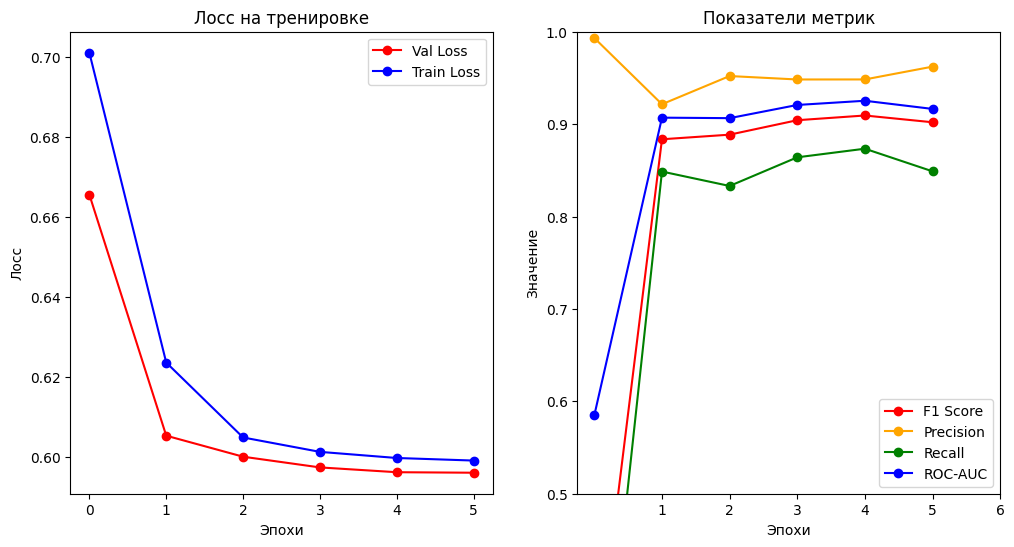

CPU times: user 8min 26s, sys: 10.5 s, total: 8min 37s
Wall time: 9min 1s


In [ ]:
%%time
#batch_size = 2048
rubert_tiny_finetuned_with_freezed_backbone, rubert_tiny_freezed_metrics = train_transformer(rubert_tiny_freezed_model,
                                                                              train_loader=train_dataloader,
                                                                              val_loader=val_dataloader,
                                                                              freeze_backbone=True,
                                                                              num_epochs=6,
                                                                              learning_rate=0.001,
                                                                              scheduler_step=2,
                                                                              scheduler_gamma=0.75)

По результатам 6 эпох модель с трансформером показывает результаты хуже, чем у рекуррентной модели:

**F1: 0.9020, Precision: 0.9622, Recall: 0.8489, ROC-AUC: 0.9165.**

Увеличение количества эпох может привести к переобучению, так как датасет недостаточно большой.

In [ ]:
torch.save(rubert_tiny_finetuned_with_freezed_backbone['optimizer'], 'rubert_tiny_freezed_optimizer.pth')
torch.save(rubert_tiny_finetuned_with_freezed_backbone['model'], 'rubert_tiny_freezed_model.pth')

In [ ]:
tokenizer.save_pretrained('bert_models/rubert_tiny_tokenizer')

('bert_models/rubert_tiny_tokenizer/tokenizer_config.json',
 'bert_models/rubert_tiny_tokenizer/special_tokens_map.json',
 'bert_models/rubert_tiny_tokenizer/vocab.txt',
 'bert_models/rubert_tiny_tokenizer/added_tokens.json',
 'bert_models/rubert_tiny_tokenizer/tokenizer.json')